In [ ]:
import numpy as np
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIReader
import os
import matplotlib.pyplot as plt
import cv2
from utils import mm2_to_px, dist_to_px
import skimage
from scipy.spatial import Delaunay
from shapely.ops import polygonize, unary_union
import math
import shapely.geometry as geometry
import shapely
from PIL import Image, ImageDraw
import tifffile as tiff
from scipy.ndimage import zoom

|2024-05-20|15:43:44.422| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-05-20|15:43:44.423| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


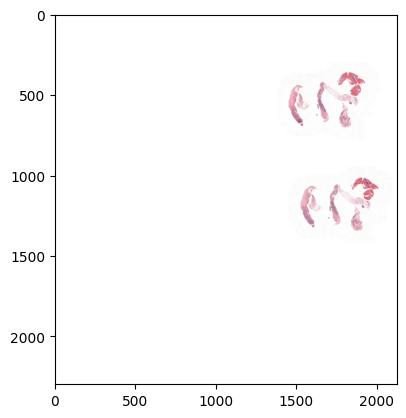

In [23]:
torch_seg_out_path = "output/seg_out"
tf_seg_out_path = "tf_seg_out/tempout"

wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images"
asap_mask_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/tissue-masks"
eval_dir = "output/eval"

wsi_name = "TC_S01_P000085_C0001_B101.tif"
# wsi_name = "104S.tif"
wsi_name_without_ext = os.path.splitext(wsi_name)[0]

asap_mask_path = os.path.join(asap_mask_dir, f"{wsi_name_without_ext}_tissue.tif")

reader = WSIReader.open(os.path.join(wsi_dir, wsi_name))
thumb = reader.slide_thumbnail(resolution=0.3125, units="power")
plt.imshow(thumb)
plt.show()

|2024-05-20|15:43:46.851| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-05-20|15:43:46.851| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


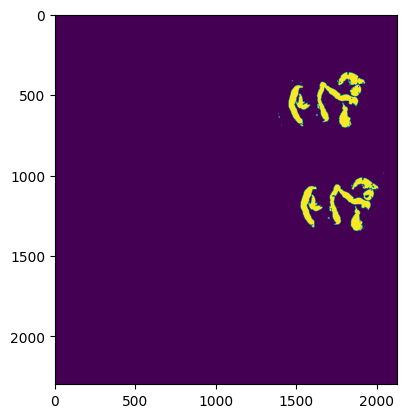

In [24]:
mask = WSIReader.open(asap_mask_path)
thumb = mask.slide_thumbnail(resolution=0.3125, units="power")[:, :, 0]
plt.imshow(thumb)
plt.show()
# factor = 64
# downsampled_image = zoom(mask, (1/factor, 1/factor))
# print(downsampled_image.shape)
# print(downsampled_image.dtype)

In [ ]:
tif = tiff.TiffFile(asap_mask_path)
print(len(tif.pages))
page = tif.pages[6]
mask = page.asarray()

plt.imshow(mask)
plt.show()